**Perform the necessary imports.**

In [1]:
import os, cv2, re, random
import numpy as np
import skimage.transform
import pandas as pd
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import skimage.transform
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Dense, Input
from sklearn.preprocessing import LabelEncoder
import skimage
from keras.utils import to_categorical



C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TRAIN_DIR = r'//192.168.5.130/Users/8nikhil/Nikhil_Banka/Keras/Cat_Dog/train/train'
Validation_dir = r'//192.168.5.130/Users/8nikhil/Nikhil_Banka/Keras/Cat_Dog/validation'
train_images_dogs_cats = [TRAIN_DIR+'/' + i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
val_list = [Validation_dir+'/'+i for i in os.listdir(Validation_dir)]

In [3]:
train_images_dogs_cats = train_images_dogs_cats[:25000]

In [4]:
def prepare_data(list_of_images):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    y = [] # labels
    
    for image in (list_of_images):
        x.append(cv2.resize(cv2.imread(image), (224,224), interpolation=cv2.INTER_CUBIC))
    
    for i in list_of_images:
        if 'dog' in i:
            y.append(1)
        elif 'cat' in i:
            y.append(0)
        else:
            print('neither cat nor dog name present in images')
            
    return np.array(x),np.array(y)

In [5]:
# Parameters 
img_size = 224
img_flat_size = img_size * img_size

# If you want to train the model -> True, otherwise -> False
Is_train = True

# If you want to load saved model -> True, otherwise -> False 
Load_model = False

# Name of the save file
save_name = 'soft1'

# Numbers of sampling to 0test the code 
num_test_sample = 20

# labels: 0 - 9
num_label = 2

# Parameters for training
num_epoch = 1

learning_rate = 1e-4
epsilon = 1e-8

batch_size = 16

# Parameter for LSTM
lstm_size = 256
step_size = 4
flatten_size = img_size

gpu_fraction = 0.3

In [6]:
# Initialize weights and bias 
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Get Variables
def weight_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

In [7]:

#LSTM Variables
Wf = weight_variable('Wf', [2048 + lstm_size, lstm_size])
Wi = weight_variable('Wi', [2048 + lstm_size, lstm_size])
Wc = weight_variable('Wc', [2048 + lstm_size, lstm_size])
Wo = weight_variable('Wo', [2048 + lstm_size, lstm_size])

bf = bias_variable('bf', [lstm_size])
bi = bias_variable('bi', [lstm_size])
bc = bias_variable('bc', [lstm_size])
bo = bias_variable('bo', [lstm_size]) 

# Attention Variables
Wa = weight_variable('Wa', [2048, 1])
Wh = weight_variable('Wh', [lstm_size, 1])



In [8]:
# Soft Attention function
def soft_attention(h_prev, a, Wa, Wh):
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # a: Result of CNN [batch_size, conv_size * conv_size, channel_size] 

    m_list = [tf.tanh(tf.matmul(a[i], Wa) + tf.matmul(h_prev, Wh)) for i in range(len(a))] 
    m_concat = tf.concat([m_list[i] for i in range(len(a))], axis = 1)                    # (?,196)
    alpha = tf.nn.softmax(m_concat)                                                       # alpha.shape = (?,196)
    z_list = [tf.multiply(a[i], tf.slice(alpha, (0, i), (-1, 1))) for i in range(len(a))] #len(z_list) = 196
    z_stack = tf.stack(z_list, axis = 2)                                                  #(?, 512, 196)
    z = tf.reduce_sum(z_stack, axis = 2)                                                  #(?, 512)
    return alpha, z
    
    
    
    
# LSTM function
def LSTM_cell(C_prev, h_prev, x_lstm, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
    
    
     #  rnn_state = C_prev
    
    
    # C_prev: Cell state from lstm of previous time step (shape: [batch_size, lstm_size])   #shape: [batch_size, 256]
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # x_lstm: input of lstm (shape: [batch_size, data_flatten_size])

    input_concat = tf.concat([x_lstm, h_prev], 1)           #shape=(1, 512+256),
    f = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)        #shape=(1, 256),
    i = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)       #shape=(1, 256), 
    c = tf.tanh(tf.matmul(input_concat, Wc) + bc)           #shape=(1, 256), 
    o = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)        #shape=(1, 256), 
    
    
    C_t = tf.multiply(f, C_prev) + tf.multiply(i, c)        # shape=(1, 256), 
    h_t = tf.multiply(o, tf.tanh(C_t))                      #shape=(1, 256), 
    
    return C_t, h_t # Cell state, Output


In [9]:
x_image  = tf.placeholder(tf.float32, shape = [None, img_size,img_size, 3])
y_target = tf.placeholder(tf.float32, shape=[None, 2])

In [10]:
x= tf.keras.applications.resnet50.preprocess_input(x_image)


In [11]:
with tf.variable_scope("ResNet50Model"):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', pooling='max', include_top=False, input_tensor=x)     #top false. Removed last 2 layers(GlobalAveragePooling2 &dense_prediction) from full model

third_last_layer_name = base_model.layers[-3].name
third_last_layer = base_model.get_layer(third_last_layer_name).output
conv_size = third_last_layer.get_shape()[1] 
conv_flat = tf.reshape(third_last_layer, [-1, conv_size*conv_size, 2048])               # shape=(?, 196, 512) 
conv_unstack = tf.unstack(conv_flat, axis = 1)    

In [12]:


rnn_batch_size = tf.shape(x_image)[0]                                           # rnn_batch_size = 1

# Initial lstm cell state and output 
rnn_state = tf.zeros([rnn_batch_size, lstm_size], tf.float32)                         # shape=(1, 256) 
rnn_out = tf.zeros([rnn_batch_size, lstm_size], tf.float32)                            # shape=(1, 256)
 
#################################### Attention!!! ####################################
for i in range(4):
    alpha, z = soft_attention(rnn_out, conv_unstack, Wa, Wh)       
    rnn_state, rnn_out = LSTM_cell(rnn_state, rnn_out, z, Wf, Wi, Wc, Wo, bf, bi, bc, bo)

######################################################################################


In [54]:
w_fc1 = weight_variable('w_fc3',[256, 2])
b_fc1 = bias_variable('b_fc3', [2])

output = tf.matmul(rnn_out, w_fc1)+b_fc1
output = tf.nn.softmax(output)
# Training 
Loss = tf.keras.backend.categorical_crossentropy(target = y_target, output = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate =0.0000005 , epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [55]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction
saver = tf.train.Saver()

sess = tf.keras.backend.get_session()
initialize_variables_list = list(set(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))^set(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='ResNet50Model')))
writer = tf.summary.FileWriter("output", sess.graph)
sess.run(initialize_variables_list )

[array([ 0.19860654, -0.19860654], dtype=float32),
 0.0,
 0.29036924,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [56]:
X_val,Y_val = prepare_data(val_list)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
Y_val = to_categorical(Y_val)

In [59]:
# Training
batch_size=16
Is_train = True
if Is_train == True:
    train_data_num =25000   #(consider only 5000 images)

    for i in range(2):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)

        batch_count = 1
    
        for j in range(0, train_data_num, batch_size):
            if j + batch_size < train_data_num:
                batch_index = [j, j + batch_size]
                
                lis_batch=[]
                for k in range(16):
                    lis_batch.append(train_images_dogs_cats[random_idx[batch_index[0]:batch_index[1]]  [k]])
                
               
            else:
                
                batch_index = [j, j + train_data_num-1]
                
                lis_batch=[]
                for k in range(16):
                    lis_batch.append(train_images_dogs_cats[random_idx[batch_index[0]:batch_index[1]][k]])
                
                
                
                
            X_train,Y_train = prepare_data(lis_batch)
            batch_x_train = np.array(X_train)
            Y_train = np.array(Y_train)
            batch_y_train = to_categorical(Y_train)
            
            
            
            
            train_batch = np.reshape(batch_x_train, (batch_x_train.shape[0], img_size, img_size, 3))
            validation_batch = np.reshape(X_val, (X_val.shape[0], img_size, img_size, 3))
            
            # Training
            optimizer.run(session=sess, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            cost = Cost.eval( session=sess, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            acc = accuracy.eval( session=sess, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            val_acc = accuracy.eval( session=sess, feed_dict = {x_image: X_val, y_target: Y_val})
           
            #saver.save(sess, 'my-model')
            # Print Progress
            print("Epoch: " + str(i+1) + ' / ' + 
                  "Batch: " + str(j) + '/' + str(train_data_num) + ' / ' + 
                  "Cost: " + str(cost) + ' / ' + 
                  "Training Accuracy: " + str(acc) + ' / ' + 
                  "Validation Accuracy: " + str(val_acc))  

        #saver.save(sess, 'saved_networks1/' + save_name)
        #saver.save(sess, 'my-model', global_step=num_epoch*1000000+batch_count)
        
        print('Model is saved!!!')

Epoch: 1 / Batch: 0/25000 / Cost: 0.1961746 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 16/25000 / Cost: 0.15351595 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 32/25000 / Cost: 0.14900097 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 48/25000 / Cost: 0.27434748 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 64/25000 / Cost: 0.16224924 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 80/25000 / Cost: 0.19507119 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 96/25000 / Cost: 0.15926498 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 112/25000 / Cost: 0.14472409 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 128/25000 / Cost: 0.16571301 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 144/25000 / Cost: 0.13786694 / Training Accuracy: 1.0 / Validation Accura

Epoch: 1 / Batch: 1296/25000 / Cost: 0.09485446 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 1312/25000 / Cost: 0.08435981 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 1328/25000 / Cost: 0.13876069 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 1344/25000 / Cost: 0.09118362 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 1360/25000 / Cost: 0.060382944 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 1376/25000 / Cost: 0.08272718 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 1392/25000 / Cost: 0.10821755 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 1408/25000 / Cost: 0.13465047 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 1424/25000 / Cost: 0.14025325 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 1440/25000 / Cost: 0.113427594 / Training Accuracy: 1.0 /

Epoch: 1 / Batch: 2576/25000 / Cost: 0.06627278 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 2592/25000 / Cost: 0.05676117 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 2608/25000 / Cost: 0.06358903 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 2624/25000 / Cost: 0.14404416 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 2640/25000 / Cost: 0.07012223 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 2656/25000 / Cost: 0.064079724 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 2672/25000 / Cost: 0.056383066 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 2688/25000 / Cost: 0.07311605 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 2704/25000 / Cost: 0.077310294 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 2720/25000 / Cost: 0.06619691 / Training Accuracy: 1.0 / V

Epoch: 1 / Batch: 3856/25000 / Cost: 0.08780212 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 3872/25000 / Cost: 0.056867007 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 3888/25000 / Cost: 0.05352517 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 3904/25000 / Cost: 0.08068431 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 3920/25000 / Cost: 0.052731086 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 3936/25000 / Cost: 0.051592976 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 3952/25000 / Cost: 0.048778206 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 3968/25000 / Cost: 0.056762133 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 3984/25000 / Cost: 0.058213577 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 4000/25000 / Cost: 0.03837669 / Training Accuracy: 1.0 

Epoch: 1 / Batch: 5136/25000 / Cost: 0.025164735 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 5152/25000 / Cost: 0.0363646 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 5168/25000 / Cost: 0.041708205 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 5184/25000 / Cost: 0.055616844 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 5200/25000 / Cost: 0.026163835 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 5216/25000 / Cost: 0.09947521 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 5232/25000 / Cost: 0.06633332 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 5248/25000 / Cost: 0.051195644 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 5264/25000 / Cost: 0.032940052 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 5280/25000 / Cost: 0.037945516 / Training Accuracy: 1.0 

Epoch: 1 / Batch: 6416/25000 / Cost: 0.05792141 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 6432/25000 / Cost: 0.050540976 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 6448/25000 / Cost: 0.03237714 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 6464/25000 / Cost: 0.032181736 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 6480/25000 / Cost: 0.03673613 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 6496/25000 / Cost: 0.1570597 / Training Accuracy: 0.875 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 6512/25000 / Cost: 0.029555095 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 6528/25000 / Cost: 0.16461359 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 6544/25000 / Cost: 0.02841662 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 6560/25000 / Cost: 0.1333373 / Training Accuracy: 0.9375 

Epoch: 1 / Batch: 7696/25000 / Cost: 0.07290628 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 7712/25000 / Cost: 0.020717807 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 7728/25000 / Cost: 0.026998578 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 7744/25000 / Cost: 0.19187088 / Training Accuracy: 0.875 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 7760/25000 / Cost: 0.03201939 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 7776/25000 / Cost: 0.01975108 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 7792/25000 / Cost: 0.036613602 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 7808/25000 / Cost: 0.022153307 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 7824/25000 / Cost: 0.022226833 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 7840/25000 / Cost: 0.03208921 / Training Accuracy: 1.0

Epoch: 1 / Batch: 8976/25000 / Cost: 0.026849594 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 8992/25000 / Cost: 0.014838574 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 9008/25000 / Cost: 0.11459684 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 9024/25000 / Cost: 0.0510257 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 9040/25000 / Cost: 0.023530515 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 9056/25000 / Cost: 0.017705565 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 9072/25000 / Cost: 0.226737 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 9088/25000 / Cost: 0.12141186 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 9104/25000 / Cost: 0.04951796 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 9120/25000 / Cost: 0.014225369 / Training Accuracy: 1.

Epoch: 1 / Batch: 10256/25000 / Cost: 0.013185754 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 10272/25000 / Cost: 0.11022833 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 10288/25000 / Cost: 0.06565346 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 10304/25000 / Cost: 0.12588991 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 10320/25000 / Cost: 0.0146557065 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 10336/25000 / Cost: 0.027760569 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 10352/25000 / Cost: 0.015194668 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 10368/25000 / Cost: 0.039042223 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 10384/25000 / Cost: 0.15383668 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 10400/25000 / Cost: 0.03450481 / Trainin

Epoch: 1 / Batch: 11520/25000 / Cost: 0.02784361 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 11536/25000 / Cost: 0.015268129 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 11552/25000 / Cost: 0.06721175 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 11568/25000 / Cost: 0.020391116 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 11584/25000 / Cost: 0.043664772 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 11600/25000 / Cost: 0.043633483 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 11616/25000 / Cost: 0.03302941 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 11632/25000 / Cost: 0.018918967 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 11648/25000 / Cost: 0.016381878 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 11664/25000 / Cost: 0.024749862 / Training Acc

Epoch: 1 / Batch: 12784/25000 / Cost: 0.037249655 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 12800/25000 / Cost: 0.013262695 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 12816/25000 / Cost: 0.013810862 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 12832/25000 / Cost: 0.019642018 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 12848/25000 / Cost: 0.03655509 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 12864/25000 / Cost: 0.016619813 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 12880/25000 / Cost: 0.019292675 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 12896/25000 / Cost: 0.01843262 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 12912/25000 / Cost: 0.014138719 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 12928/25000 / Cost: 0.018203333 / Training Accur

Epoch: 1 / Batch: 14048/25000 / Cost: 0.088925175 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 14064/25000 / Cost: 0.013845911 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 14080/25000 / Cost: 0.015033005 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 14096/25000 / Cost: 0.033647876 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 14112/25000 / Cost: 0.020520711 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 14128/25000 / Cost: 0.019513063 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 14144/25000 / Cost: 0.028265517 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 14160/25000 / Cost: 0.10186413 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 14176/25000 / Cost: 0.06848064 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 14192/25000 / Cost: 0.0105289165 / Trai

KeyboardInterrupt: 

In [61]:
saver.save(sess, os.path.join(os.getcwd(), 'Final.ckpt'))

'C:\\Users\\8nikhil\\Soft Attention cat dog\\Final.ckpt'

In [17]:
TEST_DIR = 'test2/' 
test_images_dogs_cats  = [TEST_DIR+i for i in os.listdir(TEST_DIR)]


In [18]:
X,Y=prepare_data(test_images_dogs_cats)
X = np.array(X)
test_x = X
test_y = Y
test_y = to_categorical(test_y)

In [21]:
test_x.shape

(35, 224, 224, 3)

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


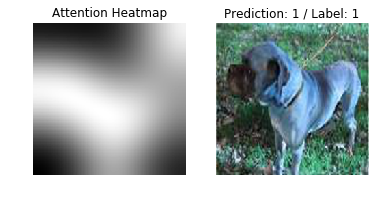

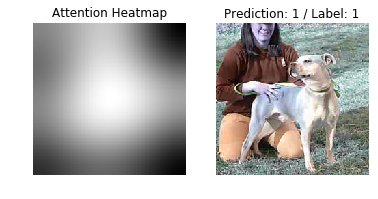

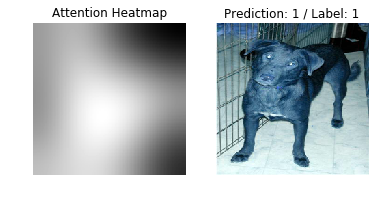

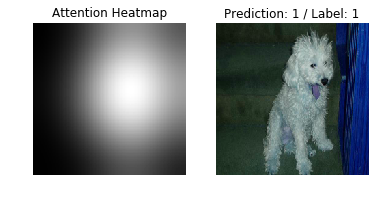

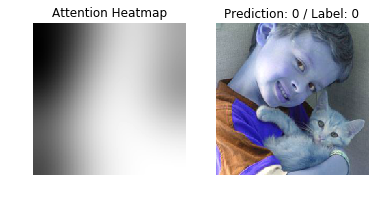

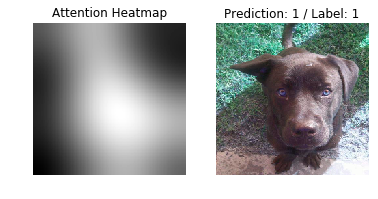

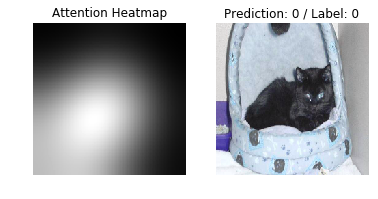

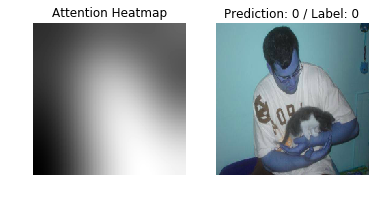

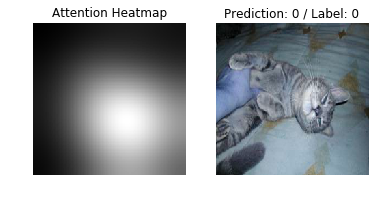

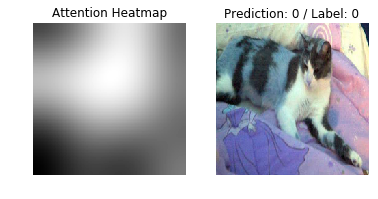

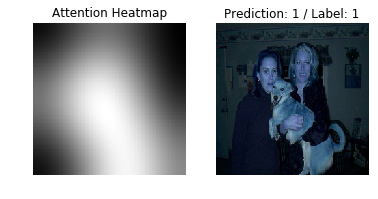

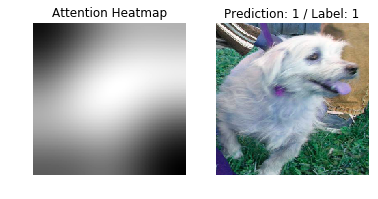

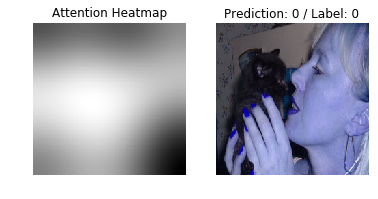

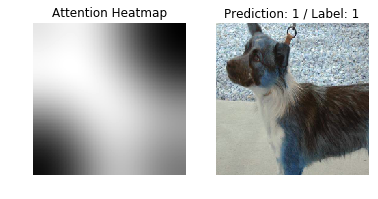

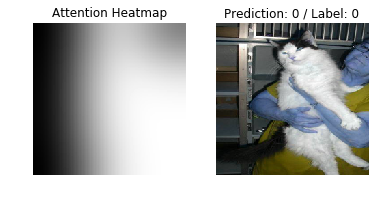

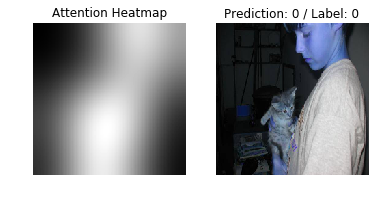

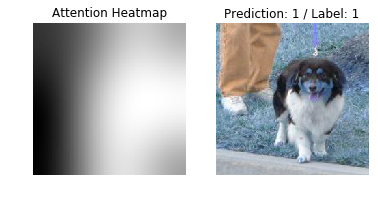

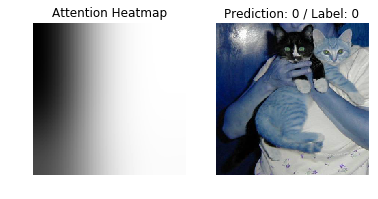

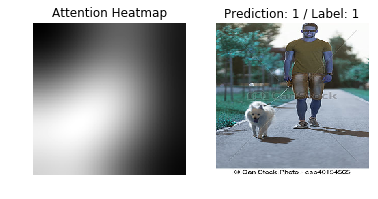

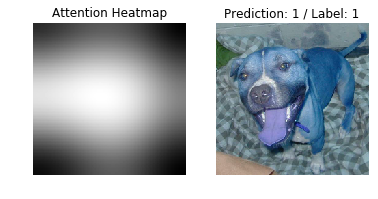

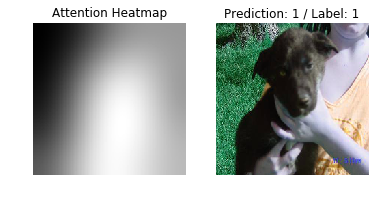

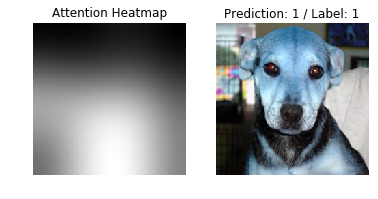

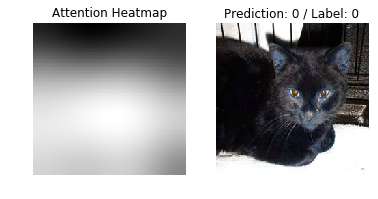

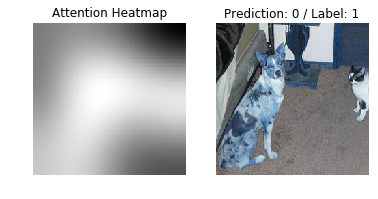

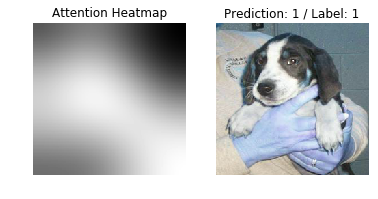

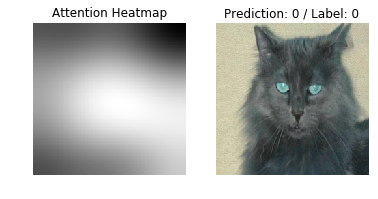

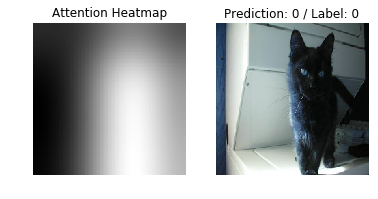

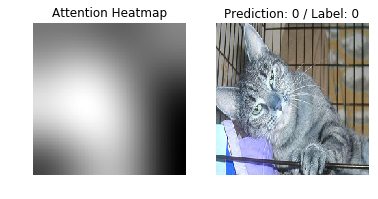

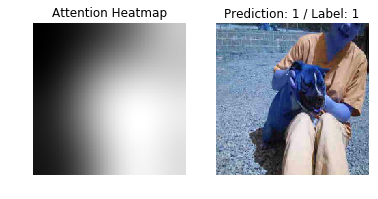

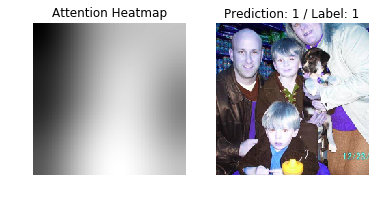

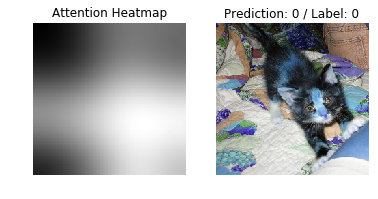

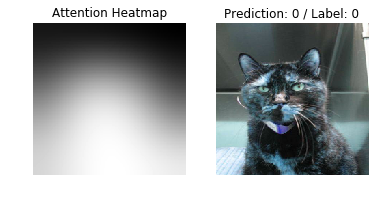

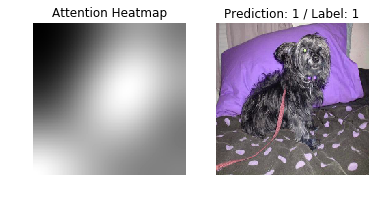

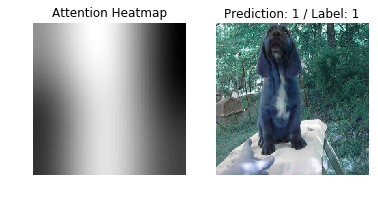

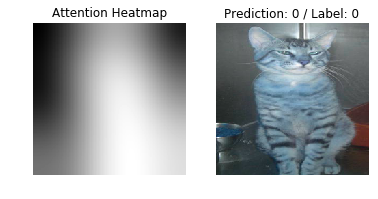

Sample Accuracy: 0.9714285714285714


In [60]:
# Sampling test indexes
num_test_sample = test_x.shape[0]

idx = random.sample(range(test_x.shape[0]), num_test_sample)

# Initialize fraction of test images and heatmap
test_fraction = np.zeros([10, img_size, img_size, 3])
heat_map = np.zeros([num_test_sample, img_size, img_size])
num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    
    # Get alpha(weight of fractions) and output for sample test data
    test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,3]))
    test_x_in = test_x_reshape[idx[idx_sample],:,:,:]
    alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_x_in], y_target: [test_y[idx[idx_sample],:]]})
    alpha_size = int(np.sqrt(alpha_.shape[1]))
    alpha_reshape = np.reshape(alpha_, (alpha_size, alpha_size))
    alpha_resize = skimage.transform.pyramid_expand(alpha_reshape, upscale = 16, sigma=20)  
    
    # Make heatmap with alpha

    # Get labels for test samples
    y_test_pred = np.argmax(output_[:])
    y_test_true = np.argmax(test_y[idx[idx_sample], :])
    
    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,2)
    ax[0].imshow(alpha_resize, cmap='gray')
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    ax[1].imshow(test_x[idx[idx_sample],:,:], cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str (y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))

    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.

# Show results 
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))

In [ ]:
alpha_